# Notes

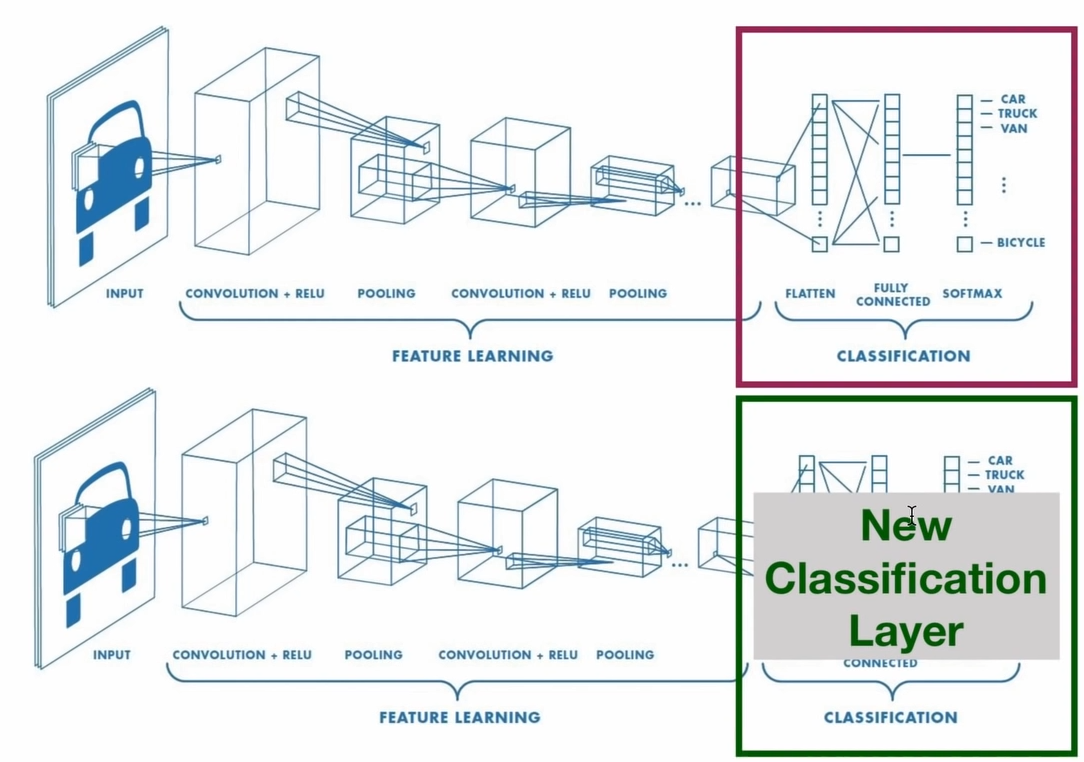

# Code

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

In [33]:
# ResNet
# ResNet-18 : network trained on more than 1M images for computer vision task (1000 object categories)

In [34]:
# Device Config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
# HyperParameters
num_epochs = 25
batch_size = 4
learning_rate = 0.01

In [49]:
# Transforms
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

# dictionary of transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [50]:
# DataLoader

# link: https://www.kaggle.com/datasets/ajayrana/hymenoptera-data

data_dir = 'Data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) 
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(class_names)

['ants', 'bees']


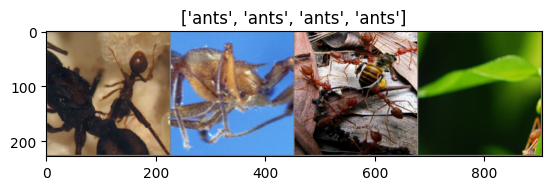

In [51]:
# plot the images
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [52]:
# A model's state dictionary (model.state_dict()) contains the learnable parameters, such as weights and biases, 
# organized as a Python dictionary. 
# It represents the current state of the model after it has been trained or updated.

In [53]:
# model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict)
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        # each epoch has training and validation phases
        for phase in ['train', 'val']:
            if phase=='train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # forward
                # track history only when in training
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    # loss
                    loss = criterion(outputs, labels)
                    
                    # backward+optimize only when in training
                    if phase == 'train':
                        # backward
                        loss.backward()
                        # update
                        optimizer.step()
                        # zero gradients
                        optimizer.zero_grad()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss:{:.4f} Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase=='val'and epoch_acc>best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
        
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [56]:
## METHOD 1
# Fine-Tune the ConvNet

# load a pre-trained model and reset final fully connected layer.

model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
num_features = model.fc.in_features
# Here, set the size of each output sample to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names))
# model.fc refers to the existing fully connected layer in the model
model.fc = nn.Linear(num_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by 'gamma' every 'step_size' epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss:0.6506 Acc:0.6270
val Loss:0.4814 Acc:0.8235

Epoch 2/10
----------
train Loss:0.5269 Acc:0.7295
val Loss:0.3618 Acc:0.8889

Epoch 3/10
----------
train Loss:0.4575 Acc:0.7828
val Loss:0.2934 Acc:0.9150

Epoch 4/10
----------
train Loss:0.4236 Acc:0.8238
val Loss:0.2598 Acc:0.9216

Epoch 5/10
----------
train Loss:0.4087 Acc:0.8156
val Loss:0.2361 Acc:0.9346

Epoch 6/10
----------
train Loss:0.4254 Acc:0.8197
val Loss:0.2224 Acc:0.9346

Epoch 7/10
----------
train Loss:0.4017 Acc:0.8033
val Loss:0.2090 Acc:0.9281

Epoch 8/10
----------
train Loss:0.3615 Acc:0.8279
val Loss:0.2062 Acc:0.9281

Epoch 9/10
----------
train Loss:0.3267 Acc:0.8934
val Loss:0.2193 Acc:0.9281

Epoch 10/10
----------
train Loss:0.3585 Acc:0.8566
val Loss:0.2123 Acc:0.9281

Training completed in 0m 39s
Best val Acc: 0.934641


In [58]:
## METHOD 2
# freeze the network except the final layer

# load a pre-trained model and reset final fully connected layer
# set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()

model_conv = models.resnet18(weights="ResNet18_Weights.DEFAULT")
for param in model_conv.parameters():
    param.requires_grad = False

num_features = model_conv.fc.in_features
# Here, set the size of each output sample to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names))
# model.fc refers to the existing fully connected layer in the model
model_conv.fc = nn.Linear(num_features, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer, step_lr_scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss:0.6075 Acc:0.6885
val Loss:0.3187 Acc:0.8824

Epoch 2/10
----------
train Loss:0.5112 Acc:0.7500
val Loss:0.1835 Acc:0.9346

Epoch 3/10
----------
train Loss:0.5158 Acc:0.7828
val Loss:0.1691 Acc:0.9281

Epoch 4/10
----------
train Loss:0.4574 Acc:0.8197
val Loss:0.1721 Acc:0.9542

Epoch 5/10
----------
train Loss:0.5108 Acc:0.7664
val Loss:0.2814 Acc:0.8954

Epoch 6/10
----------
train Loss:0.4118 Acc:0.8320
val Loss:0.1841 Acc:0.9412

Epoch 7/10
----------
train Loss:0.3342 Acc:0.8443
val Loss:0.2328 Acc:0.9346

Epoch 8/10
----------
train Loss:0.3263 Acc:0.8893
val Loss:0.1857 Acc:0.9412

Epoch 9/10
----------
train Loss:0.2900 Acc:0.8730
val Loss:0.1925 Acc:0.9412

Epoch 10/10
----------
train Loss:0.2953 Acc:0.8402
val Loss:0.1829 Acc:0.9477

Training completed in 0m 32s
Best val Acc: 0.954248
